In [1]:
from collections import Counter, defaultdict
from modules.gradient_descent import minimize_stochastic
import math, random
import numpy as np
import json
import csv
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
matplotlib inline

# Regressão Linear Simples

Em uma aula anterior, usamos a função de correlação para medir a força da relação linear entre duas variáveis. Para a maioria das aplicações, saber que esse relacionamento linear existe não é suficiente. Queremos ser capazes de entender a natureza do relacionamento. É aqui que vamos usar a regressão linear simples.

## O modelo

Lembre-se de que estávamos investigando a relação entre o número de amigos de um usuário da DataSciencester e a quantidade de tempo que ele passou no site todos os dias. Suponhamos que você se convenceu de que ter mais amigos faz com que as pessoas passem mais tempo no site, em vez de usar uma das explicações alternativas que discutimos.

O diretor do departamento de Engajamento solicita que você crie um modelo descrevendo esse relacionamento. Desde que você encontrou um relacionamento linear muito forte, um lugar natural para começar é um modelo linear.

Em particular, você supõe que existem constantes $\alpha$ (alfa) e $\beta$ (beta) tais que:

$$y_i = \beta x_i + \alpha + \epsilon_i$$

onde $y_i$ é o número de minutos que o usuário $i$ gasta no site diariamente, $x_i$ é o número de amigos que o usuário $i$ possui e $\epsilon_i$ é um termo de erro (esperançosamente pequeno) que representa o fato de que existem outros fatores não explicados por este modelo simples.

Supondo que tenhamos determinado alfa e beta, fazemos previsões simplesmente com:

In [3]:
def predict(alpha, beta, x_i):
    return beta * x_i + alpha

Como escolhemos alfa e beta? Bem, qualquer escolha de alfa e beta nos dá uma saída prevista para cada entrada $x_i$. Como sabemos a saída real $y_i$, podemos calcular o erro de cada par:

In [4]:
def error(alpha, beta, x_i, y_i):
    """the error from predicting beta * x_i + alpha
    when the actual value is y_i"""
    return y_i - predict(alpha, beta, x_i)

O que realmente gostaríamos de saber é o erro total em todo o conjunto de dados. Mas não queremos apenas adicionar os erros. Se a previsão para $x_1$ for muito alta e a previsão para $x_2$ for muito baixa, os erros podem ser cancelados.

Então, em vez disso, somamos os erros quadrados:

In [5]:
def sum_of_squared_errors(alpha, beta, x, y):
    return sum(error(alpha, beta, x_i, y_i) ** 2
               for x_i, y_i in zip(x, y))

A *solução de mínimos quadrados (least squares solution)*  é escolher o alfa e o beta que tornam o `sum_of_squared_errors` o menor possível.

Usando o cálculo (ou álgebra tediosa), os alfa e beta minimizadores de erros são dados por:

In [6]:
def least_squares_fit(x,y):
    """given training values for x and y,
    find the least-squares values of alpha and beta"""
    correlationxy = np.corrcoef(x, y)[0][1]
    beta = correlationxy * np.std(y) / np.std(x)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

Sem passar pela matemática exata, vamos pensar em por que isso pode ser uma solução razoável. A escolha do alfa simplesmente diz que quando vemos o valor médio da variável independente $x$, predizemos o valor médio da variável dependente $y$.

A escolha de beta significa que quando o valor de entrada aumenta pelo desvio padrão de $x$, a previsão de $y$ aumenta pela correlação entre $x$ e $y$ multiplicada pelo desvio padrão de $y$ (`correlationxy * np.std(y)`). No caso em que $x$ e $y$ estão perfeitamente correlacionados, um aumento de um desvio padrão em $x$ resulta em um aumento de um desvio padrão de $y$ na predição. Quando eles são perfeitamente anti-correlacionados, o aumento em $x$ resulta em uma *diminuição* no valor da previsão. E quando a correlação é *zero*, o beta é *zero*, o que significa que as alterações em $x$ não afetam a previsão.

Para um pouco mais sobre a intuição dessa fórmula, veja este [vídeo](https://www.khanacademy.org/math/ap-statistics/bivariate-data-ap/least-squares-regression/v/calculating-the-equation-of-a-regression-line).

É fácil aplicar isso aos dados que vimos anteriormente, que contêm o número de amigos e minutos diários gastos online para diversas pessoas do nosso sistema. Tais dados estão convenientemente salvos [aqui](https://www.dropbox.com/s/uxapbmyjxp8l3yx/numfriends_dailyminutes.csv?dl=0).

In [7]:
df = pd.read_csv('./data/numfriends_dailyminutes.csv')
df

,daily_minutes_good,num_friends_good
0,68.77,49
1,51.25,41
2,52.08,40
3,38.36,25
4,44.54,21
5,57.13,21
6,51.40,19
7,41.42,19
8,31.22,18
9,34.76,18


Agora vamos carregar essas duas colunas para duas listas e aplicar o *least squares fit*:

In [8]:
num_friends_good = df['num_friends_good'].values
daily_minutes_good = df['daily_minutes_good'].values

In [9]:
alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)
print("alfa = ", alpha)
print("beta = ", beta)

alfa =  22.947552413468973
beta =  0.9038659456058726


Isso fornece valores de alfa = 22,95 e beta = 0,903. Portanto, nosso modelo diz que esperamos que um usuário com $n$ amigos gaste $22.95 + n \times 0.903$ minutos no site todos os dias. Ou seja, prevemos que um usuário sem amigos no DataSciencester ainda gastaria cerca de 23 minutos por dia no site. E para cada amigo adicional, esperamos que um usuário passe quase mais um minuto no site todos os dias.

Abaixo, plotamos a linha de previsão para ter uma noção de quão bem o modelo se ajusta aos dados observados.

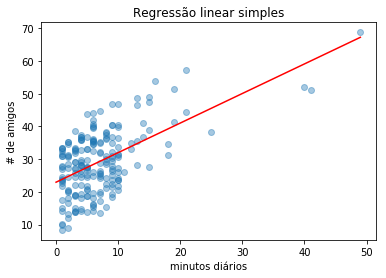

In [10]:
fig = plt.figure()
plt.scatter(num_friends_good, daily_minutes_good, alpha=0.4)
x = [0, max(num_friends_good)]
y = [predict(alpha, beta, x[0]), predict(alpha, beta, x[1])]
plt.plot(x,y,'r')
plt.ylabel("# de amigos")
plt.xlabel("minutos diários")
plt.title("Regressão linear simples")
plt.show()
fig.savefig('simpleLR.png', dpi=150)

É claro que precisamos de uma maneira melhor de descobrir o quão bem nós ajustamos os dados do que simplesmente encarar o gráfico da regressão. Uma medida comum é o coeficiente de determinação (ou R-quadrado, ou $R^2$, ou R-dois), que mede a fração da variação total na variável dependente (o $y$) que é capturada pelo modelo:

In [11]:
def total_sum_of_squares(y):
    """the total squared variation of y_i's from their mean"""
    de_mean_y = y - y.mean(keepdims=True)
    return sum(v ** 2 for v in de_mean_y)
    #return sum(v ** 2 for v in de_mean(y))

def r_squared(alpha, beta, x, y):
    """the fraction of variation in y captured by the model, which equals
    1 - the fraction of variation in y not captured by the model"""

    return 1.0 - (sum_of_squared_errors(alpha, beta, x, y) /
                  total_sum_of_squares(y))


In [12]:
R2 = r_squared(alpha, beta, num_friends_good, daily_minutes_good)
print("R2 = ", R2)

R2 =  0.32910783778363006


Agora, escolhemos o alfa e o beta que minimizaram a soma dos quadrados dos erros de previsão. Um modelo linear que poderíamos ter escolhido é "sempre prever a média de $y$" (correspondendo a `alpha = np.mean(y)` e `beta = 0`), cuja soma dos erros quadrados é exatamente igual a sua soma total de quadrados. Isso significa um $R^2$ de zero, que indica um modelo que (obviamente, neste caso) não funciona melhor do que apenas prever a média.

Claramente, o modelo de mínimos quadrados deve ser pelo menos tão bom quanto esse, o que significa que a soma dos erros quadrados é no máximo a soma total de quadrados, o que significa que o $R^2$ deve ser pelo menos zero. E a soma dos erros quadrados deve ser pelo menos $0$, o que significa que o $R^2$ pode ser no máximo $1$.

Quanto maior for o $R^2$, melhor o nosso modelo se ajusta aos dados. Aqui nós calculamos um $R^2$ de $0.329$, o que nos diz que o nosso modelo está apenas bem em ajustar os dados, e que claramente existem outros fatores em jogo.

## Usando o gradiente descendente

Já fizemos algo parecido com o que vamos fazer agora na aula sobre o *gradiente descendente*, mas como o esforço é pequeno aqui, vamos relembrar. 

Se escrevermos `theta = [alpha, beta]`, então podemos resolver o problema da regressão linear simples usando gradiente descendente:

In [13]:
def squared_error(x_i, y_i, theta):
    alpha, beta = theta
    return error(alpha, beta, x_i, y_i) ** 2

def squared_error_gradient(x_i, y_i, theta):
    alpha, beta = theta
    return [-2 * error(alpha, beta, x_i, y_i),       # alpha partial derivative
            -2 * error(alpha, beta, x_i, y_i) * x_i] # beta partial derivative


In [14]:
print("gradient descendente:")
# choose random value to start
random.seed(0)
theta = [random.random(), random.random()]
alpha, beta = minimize_stochastic(squared_error,
                                  squared_error_gradient,
                                  num_friends_good,
                                  daily_minutes_good,
                                  theta,
                                  0.0001)
print("alfa =", alpha)
print("beta =", beta)

gradient descendente:
alfa = 22.93746417548679
beta = 0.9043371597664965


Usando os mesmos dados obtemos alfa = 22,93, beta = 0,905, que são valores muito próximos das respostas exatas.

## Estimação da Máxima Verossimilhança

Por que escolher os mínimos quadrados? Uma justificativa envolve a estimativa de máxima verossimilhança.

Imagine que temos uma amostra de dados $v_1, \cdots, v_n$ que vem de uma distribuição que depende de algum parâmetro desconhecido $\theta$:

$$p(v_1, \cdots, v_n~|~\theta)$$

Se não conhecêssemos theta, poderíamos nos virar e pensar nessa quantidade como a probabilidade de $\theta$ dada a amostra:

$$L(\theta~|~v_1, \cdots, v_n)$$

Sob essa abordagem, o mais provável $\theta$ é o valor que maximiza essa função de verossimilhança; isto é, o valor que torna os dados observados os mais prováveis. No caso de uma distribuição contínua, na qual temos uma função de distribuição de probabilidade e não uma função de massa de probabilidade, podemos fazer a mesma coisa.

De volta à regressão. Uma suposição que muitas vezes é feita sobre o modelo de regressão simples é que os erros de regressão são normalmente distribuídos com média $0$ e algum desvio padrão (conhecido) $\sigma$. Se esse for o caso, a probabilidade baseada em ver um par $(x_i, y_i)$ é:

$$L(\alpha, \beta~|~x_i, y_i, \sigma) = \frac{1}{\sqrt{2\pi\sigma}}\exp{\big(\frac{-(y_i-\alpha-\beta x_i)^2}{2\sigma^2}\big)}$$

A probabilidade baseada em todo o conjunto de dados é o produto das probabilidades individuais, que é maior precisamente quando alfa e beta são escolhidos para minimizar a soma dos erros quadrados. Ou seja, nesse caso (e com essas suposições), minimizar a soma dos erros quadrados é equivalente a maximizar a probabilidade dos dados observados.